In [454]:
import numpy as np
import importlib
import matplotlib.pyplot as plt
import data_utils
importlib.reload(data_utils)
import pipeline
importlib.reload(pipeline)
import pipelines
importlib.reload(pipelines)
import draw_utils
importlib.reload(draw_utils)
import linreg_utils
importlib.reload(linreg_utils)
from pipeline import Pipeline
import sklearn.datasets as datasets

Ради интереса я решил написать свою мини-библиотеку, с помощью которой можно конфигурировать обработку данных и делать красивые визуализации

### Генерация данных

In [455]:
data = [
    Pipeline('line').generate(['X', 'Y'], datasets.make_classification, n_samples=150,
        n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, class_sep=2),
    Pipeline('moons').generate(['X', 'Y'], datasets.make_moons, n_samples=150, noise=0.15),
    Pipeline('circles').generate(['X', 'Y'], datasets.make_circles, n_samples=150, noise=0.15, factor=0.5),
    Pipeline('circles').generate(['X', 'Y'], datasets.make_blobs, n_samples=150)
]

for d in data:
    d.transform('X', 'X', data_utils.to_mat)
    d.transform('Y', 'Y', data_utils.to_mat)
    d.process()

In [456]:
prepare = Pipeline('prepare')
prepare.subpipeline(pipelines.transform_data())
prepare.subpipeline(pipelines.prepare_data())

def generate_grid(X):
    h =  (X[:, 1].max() - X[:, 1].min()) / 50
    x_min, x_max = X[:, 0].min()-0.5 , X[:, 0].max()+0.5
    y_min, y_max = X[:, 1].min()-0.5 , X[:, 1].max()+0.5    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return np.c_[xx.ravel(), yy.ravel()], xx, yy

prepare.transform('X', ['grid', 'xx', 'yy'], generate_grid)
prepare.subpipeline(pipelines.prepare_data('grid', ''))

### Визуализация данных

In [457]:
def draw_data(stats=[]):
    def do_draw_data(ax, p):
        X = p.val('X')
        y = np.ravel(p.val('Y').astype(np.bool8))
        X_b = X[y]
        X_r = X[np.invert(y)]

        ax.set_title(p.name)
        ax.scatter(np.ravel(X_b[:, 0]), np.ravel(X_b[:, 1]), marker='o', c='#0000FF', s=150, alpha=0.7, label='blue')
        ax.scatter(np.ravel(X_r[:, 0]), np.ravel(X_r[:, 1]), marker='o', c='#FF0000', s=150, alpha=0.7, label='red')
        if len(stats):
            draw_utils.draw_stats(ax, p, stats)
        
        if p.has('grid_pred'):
            Z = p.val('grid_pred')
            Z = Z.reshape(p.val('xx').shape) 
            cs = plt.contourf(p.val('xx'), p.val('yy'), Z, cmap=plt.cm.RdBu, alpha=.5, levels=np.arange(0.0, 1.005, 0.1))
            plt.colorbar(cs)

        plt.xlim()
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()
        
        ax.grid(True)

    return do_draw_data

def draw_train_results(title, pipes):
    draws = [
        draw_data(['accuracy', 'recall', 'precision', 'f1_measure']),
        draw_utils.draw_metric(["loss"]),
        draw_utils.draw_compare_stats('W', ['X', 'Y', 'bias'])]
    draw_utils.draw_plots(pipes, draws, title=title, max_cols=3)

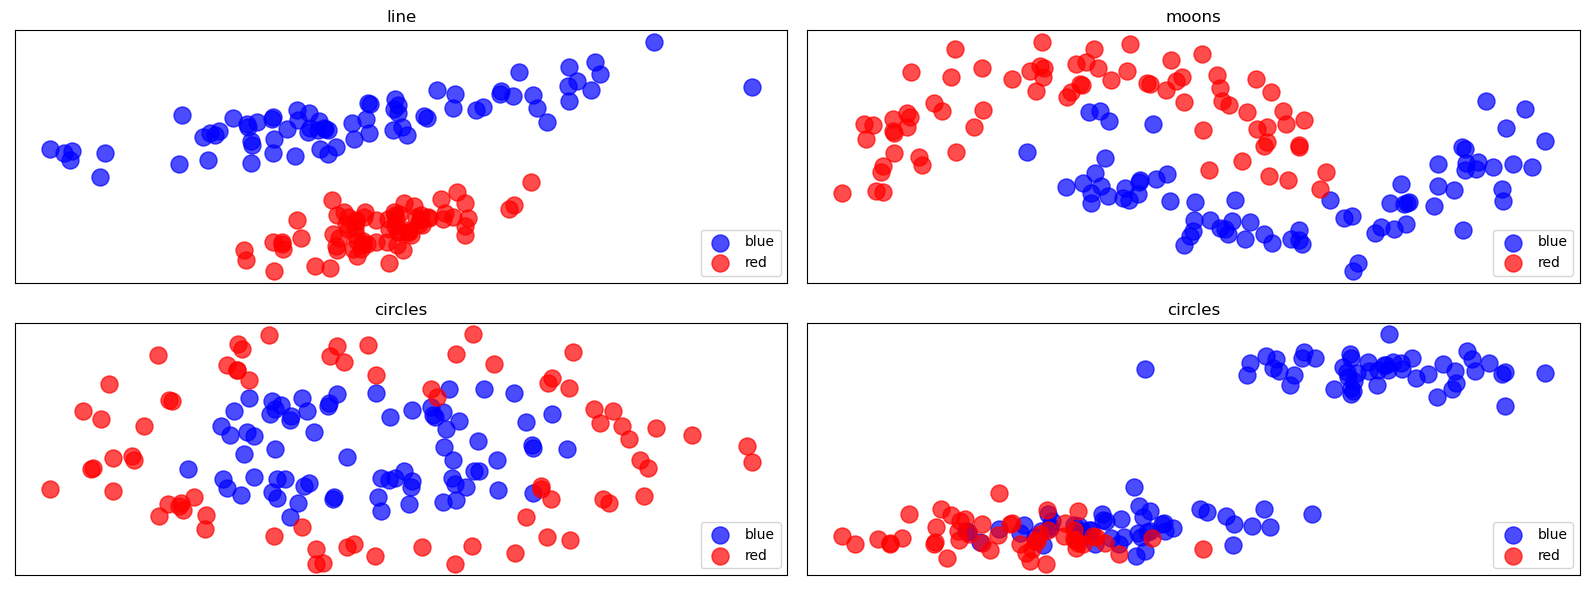

In [458]:
draw_utils.draw_plots(data, draw_data())

### Логистическая регрессия

In [459]:
reg = Pipeline('reg')
reg.subpipeline(prepare)
reg.subpipeline(pipelines.train_model([pipelines.gradient_descent(), pipelines.regularization()], pred=pipelines.classify_binary()))
reg.subpipeline(pipelines.predict('grid', 'grid'))
args = {'_batch':20, '_loss_BCE':True, '_act_sigmoid':True, '_threshold':0.5, '_conf_mat':True}

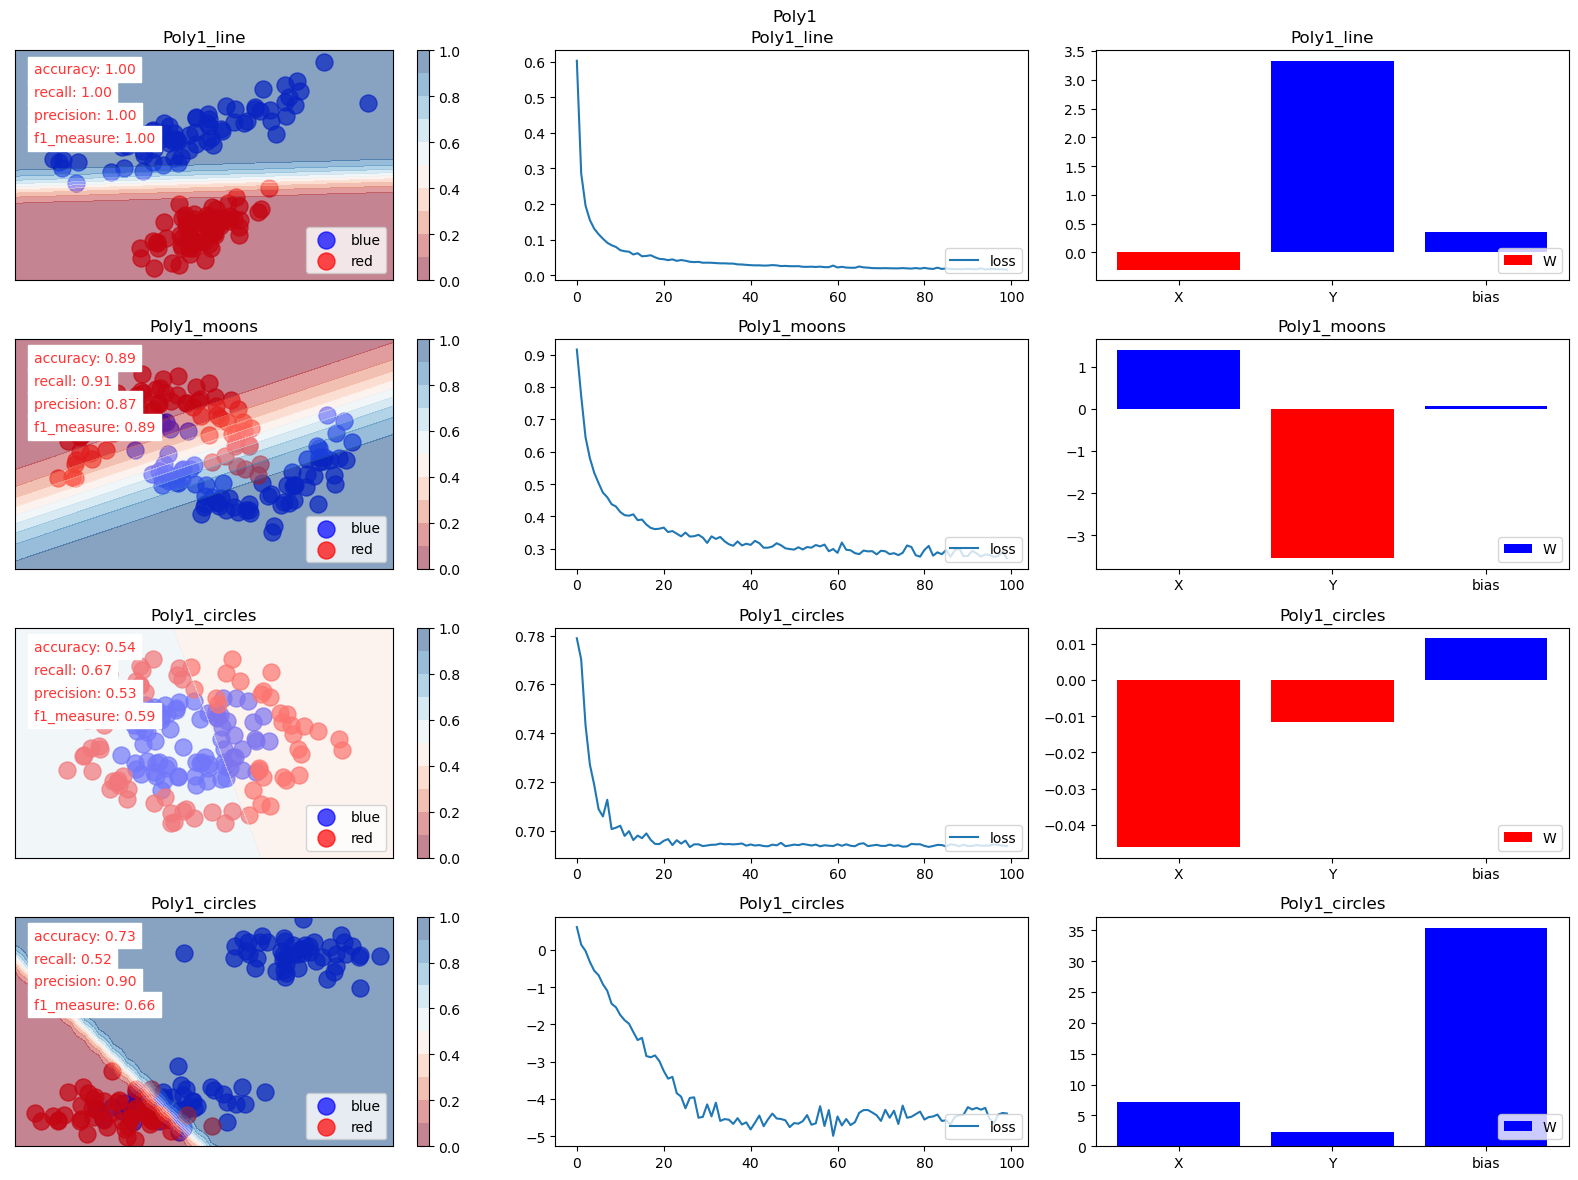

In [460]:
pipes = reg.apply_copy("Poly1", data, **args, _lr=0.1, _epochs=100, _poly=1)
draw_train_results('Poly1', pipes)

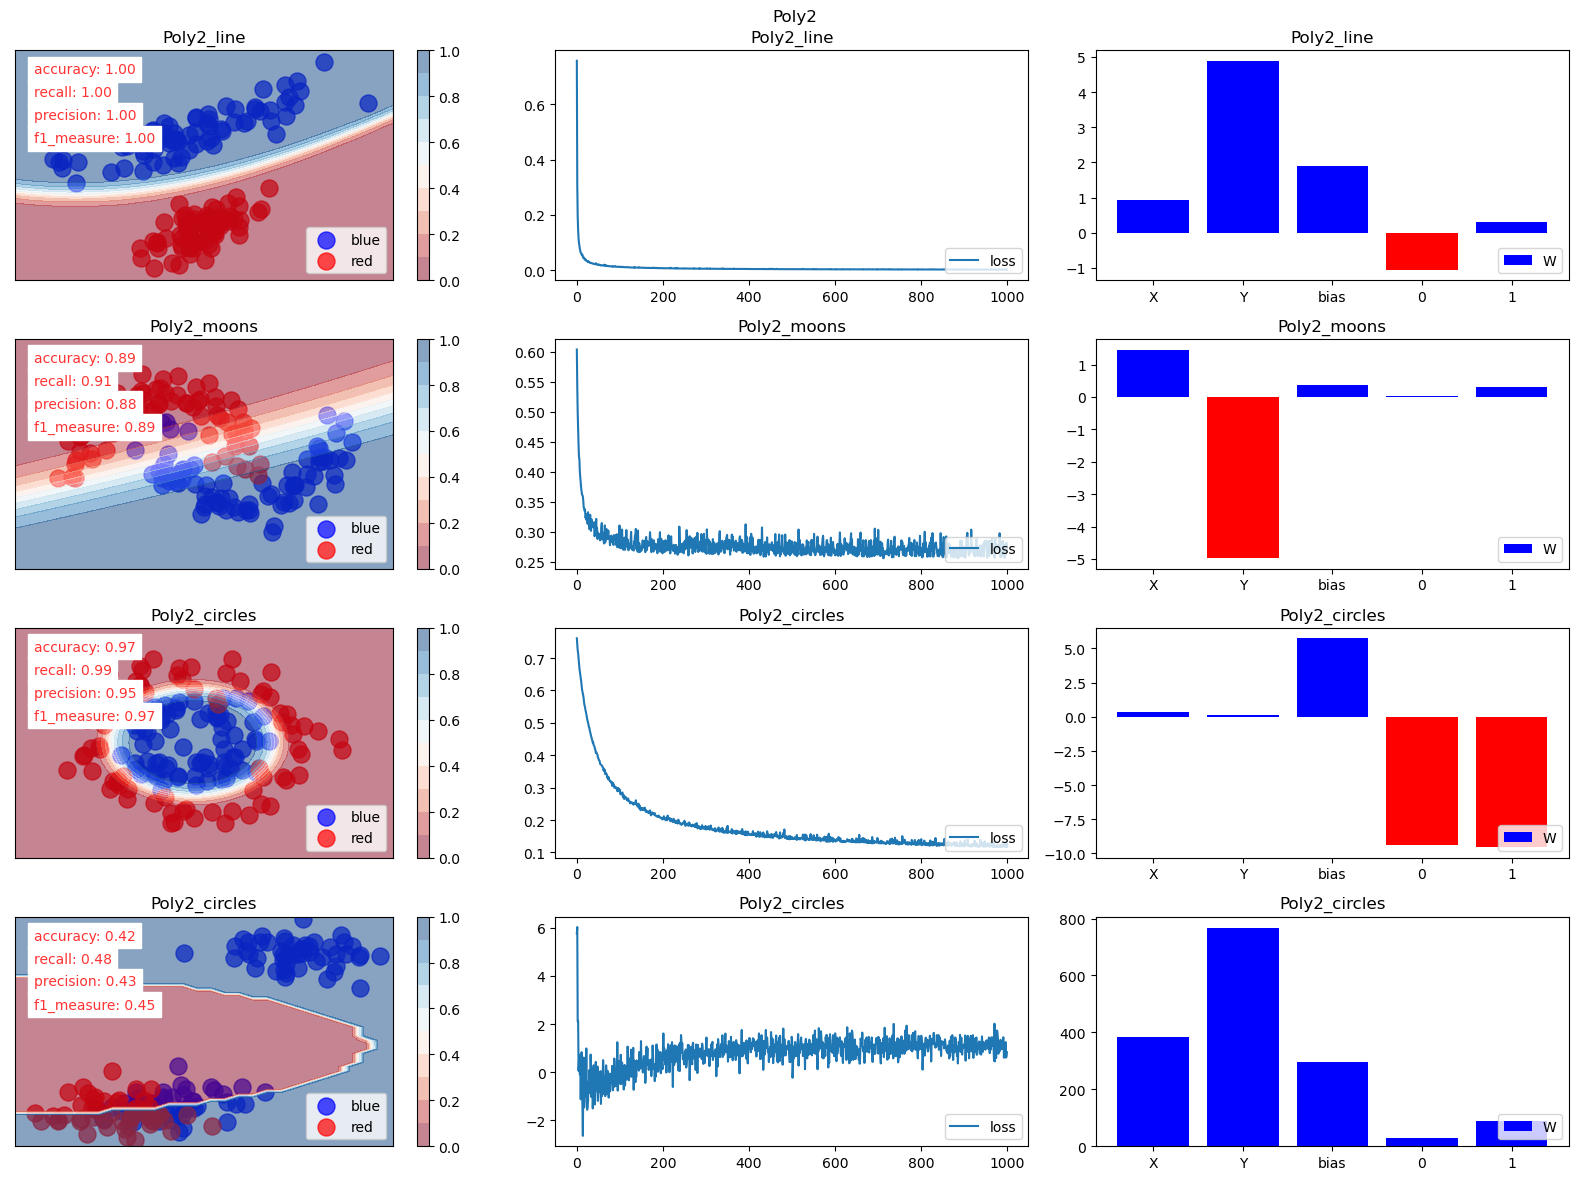

In [461]:
pipes = reg.apply_copy("Poly2", data, **args, _lr=0.1, _epochs=1000, _poly=2)
draw_train_results('Poly2', pipes)

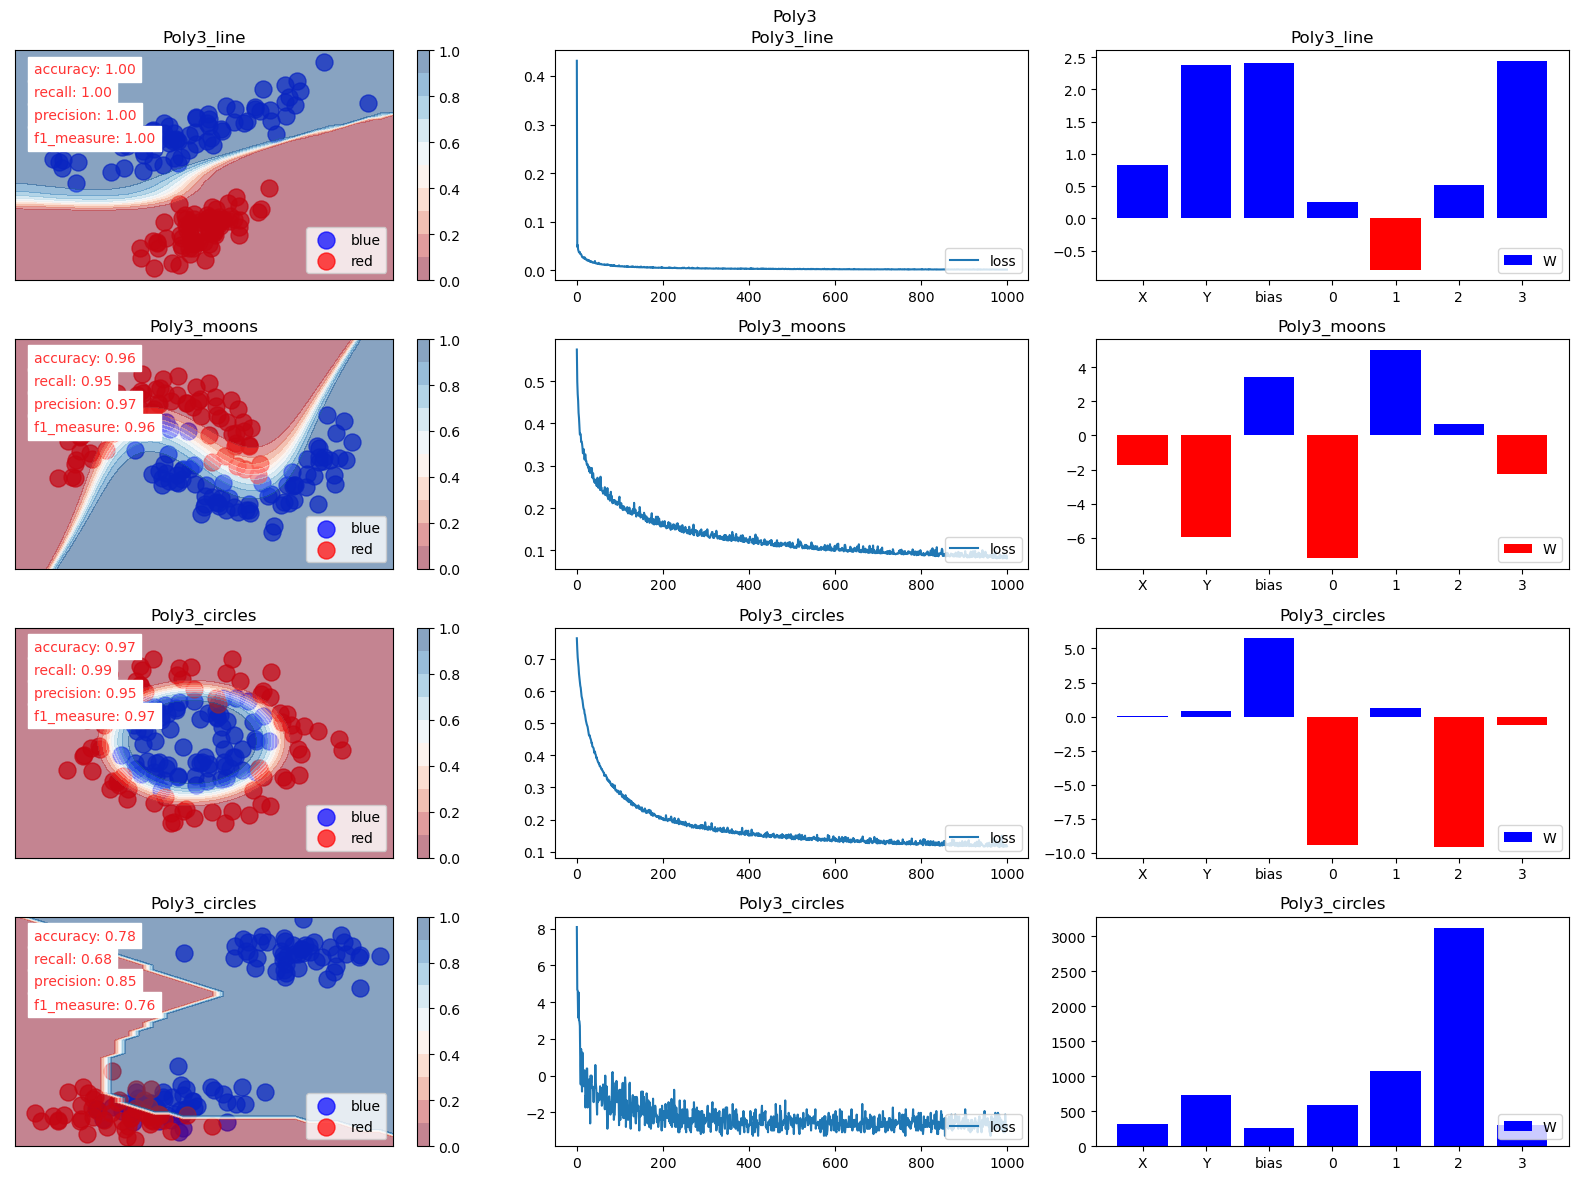

In [462]:
pipes = reg.apply_copy("Poly3", data, **args, _lr=0.1, _epochs=1000, _poly=3)
draw_train_results('Poly3', pipes)

### Полиноминальная регрессия с разной регуляризацией

#### Без регуляризации

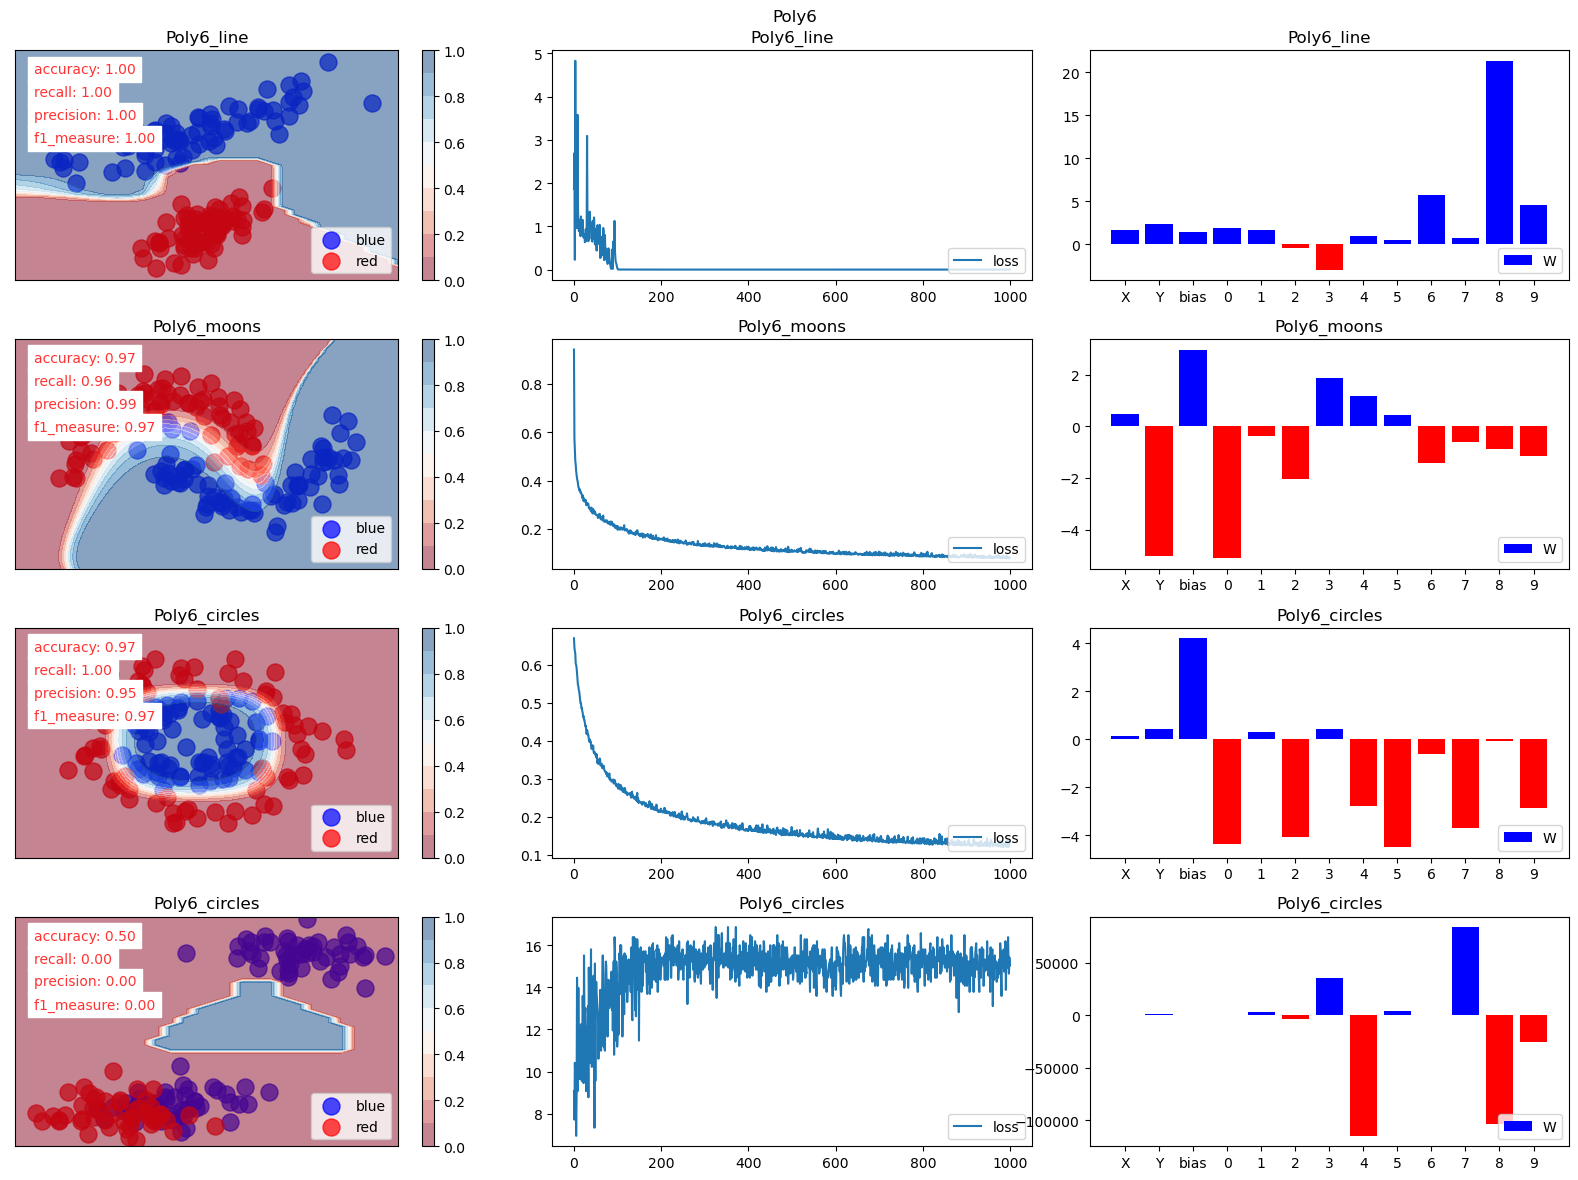

In [463]:
pipes = reg.apply_copy("Poly6", data, **args, _lr=0.05, _epochs=1000, _poly=6)
draw_train_results('Poly6', pipes)

#### Lasso регуляризация

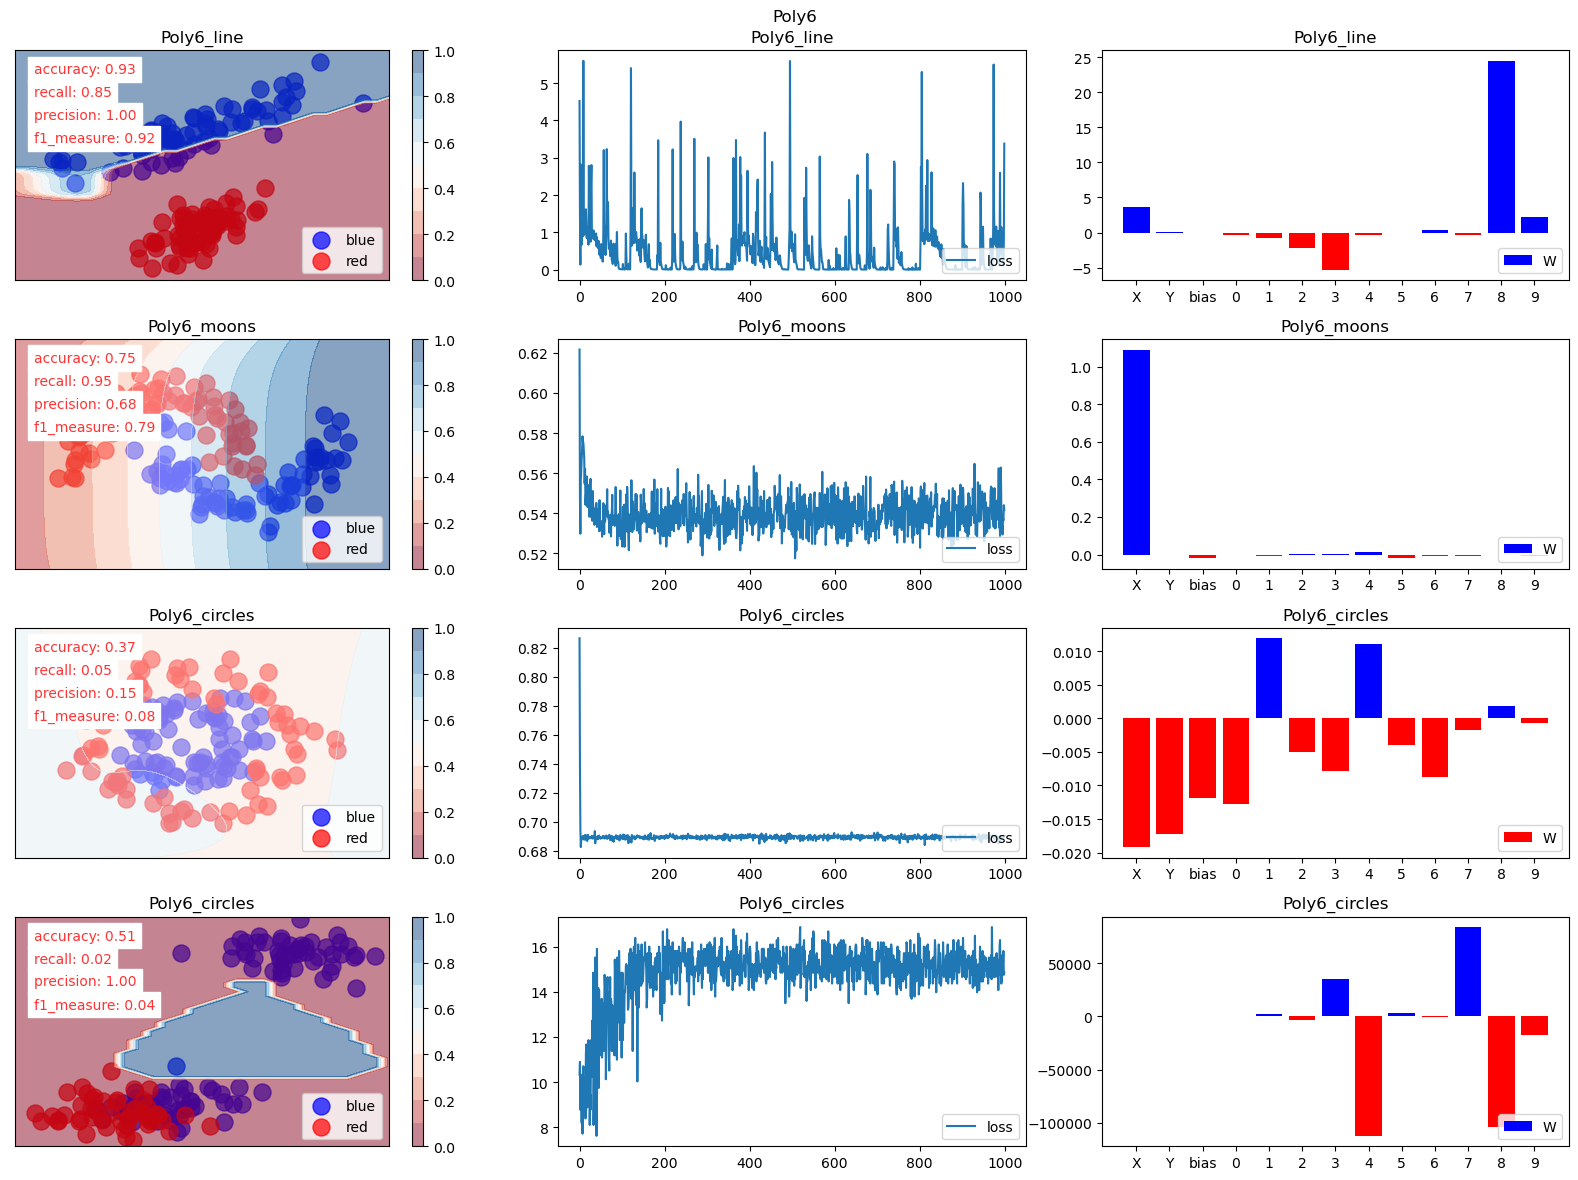

In [464]:
pipes = reg.apply_copy("Poly6", data, **args, _lr=0.05, _epochs=1000, _poly=6, _lasso_l=0.25)
draw_train_results('Poly6', pipes)

#### Ridge регуляризация

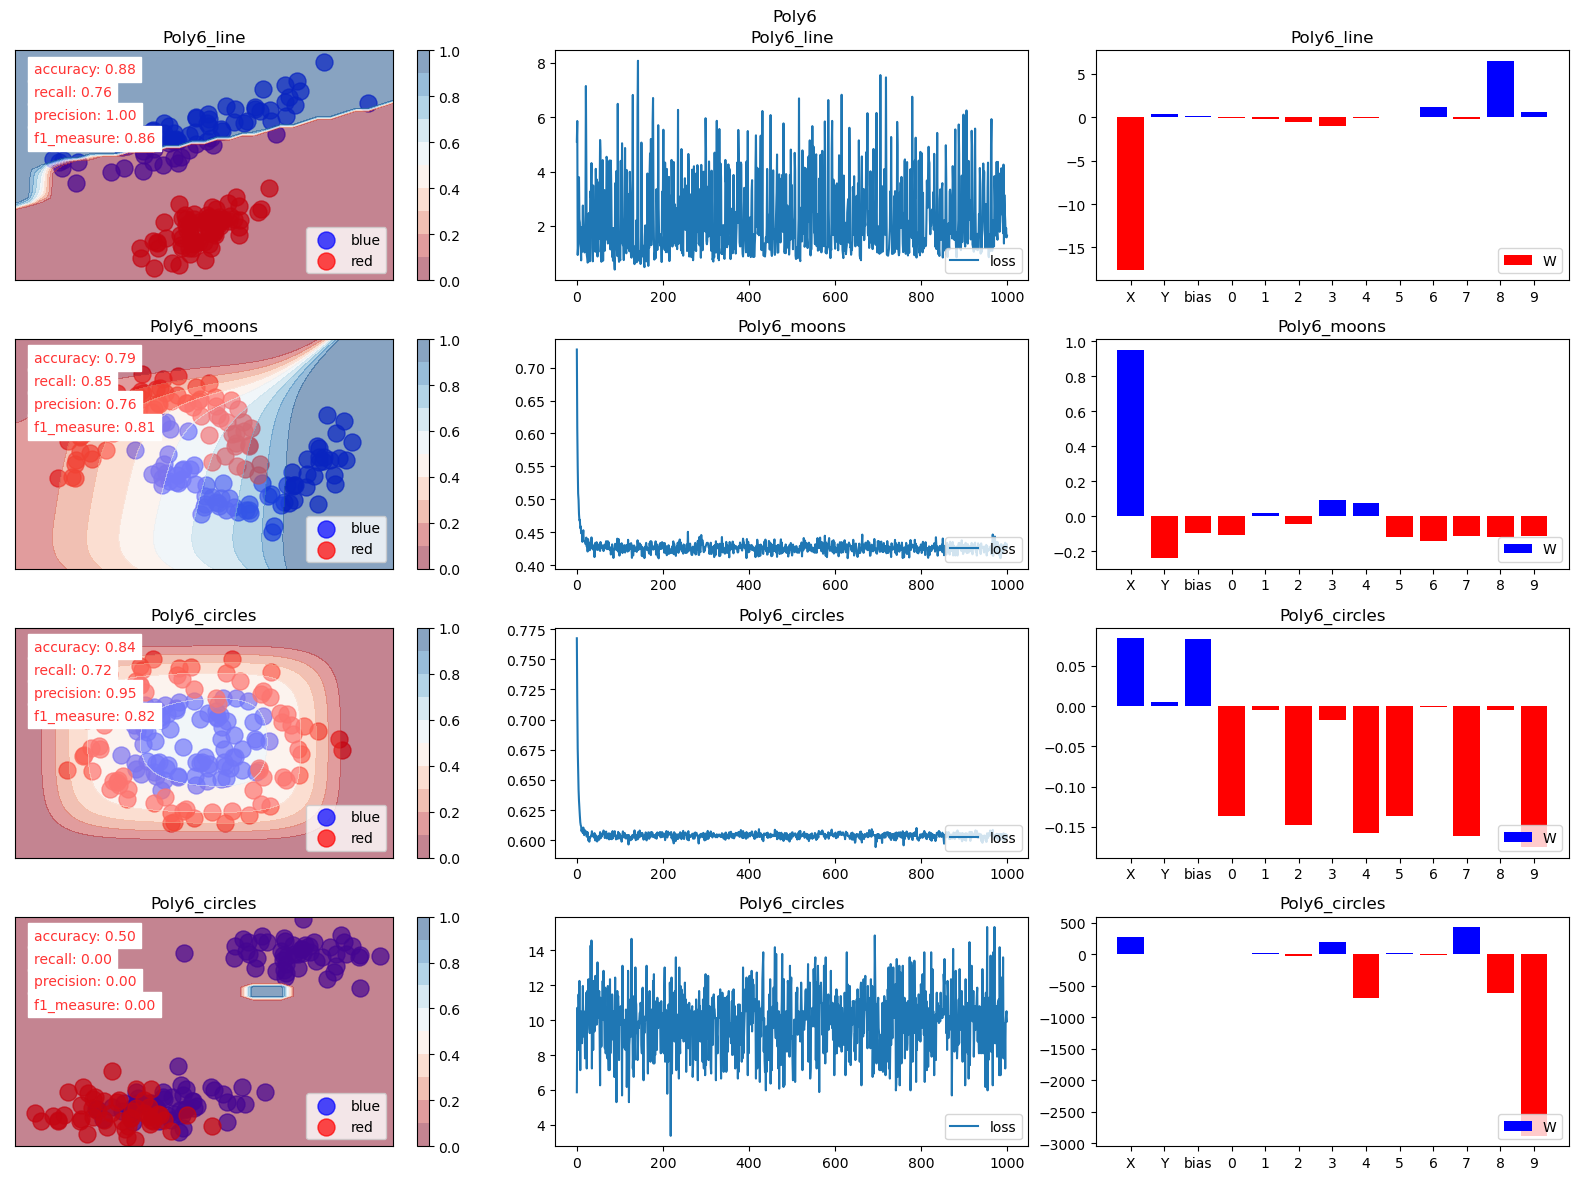

In [465]:
pipes = reg.apply_copy("Poly6", data, **args, _lr=0.05, _epochs=1000, _poly=6, _ridge_l=0.25)
draw_train_results('Poly6', pipes)

#### Ridge + Lasso регуляризация

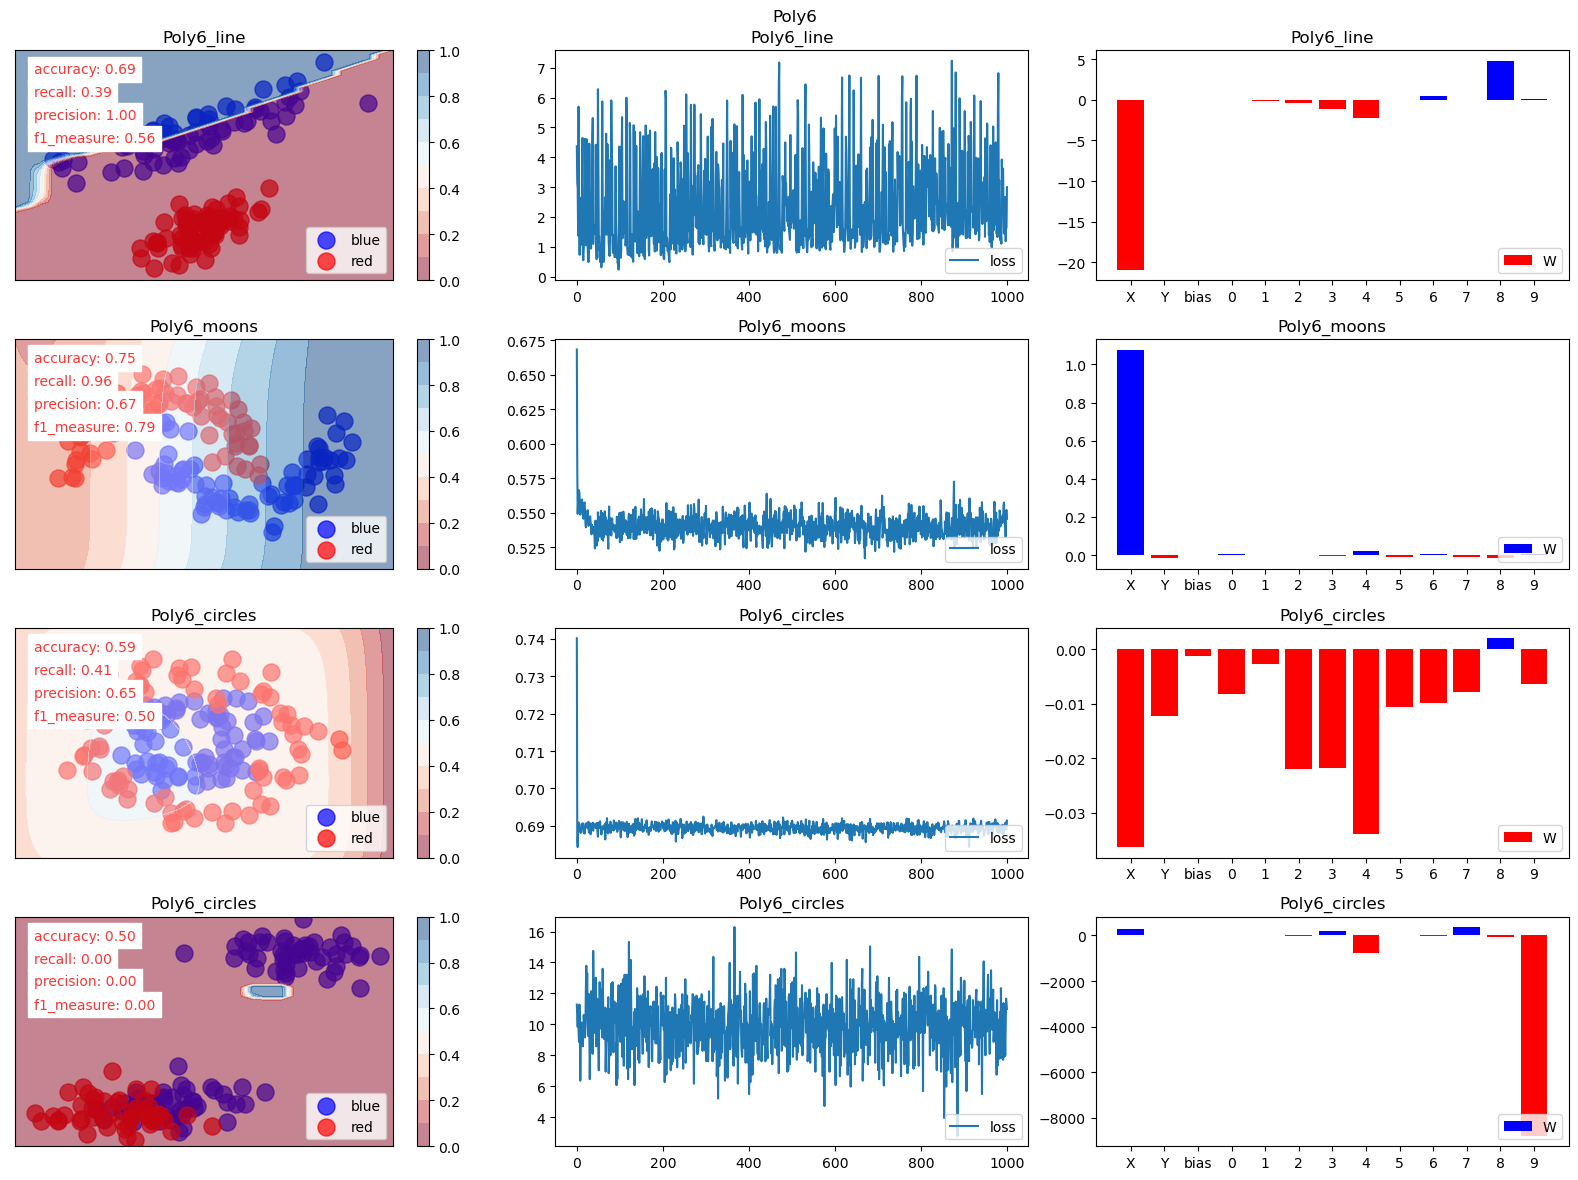

In [466]:
pipes = reg.apply_copy("Poly6", data, **args, _lr=0.05, _epochs=1000, _poly=6, _ridge_l=0.25, _lasso_l=0.25)
draw_train_results('Poly6', pipes)